# Lagged cross-covariance analysis

Resolution: 30-degree latitudinal bands, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to latitudinal bands and resample to monthly averages within each band
df_sif_monthly = (
    utils.regrid(DS_sif, res=30)
    .groupby(["lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    utils.regrid(DS_xco2, res=30)
    .groupby(["lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lat", "time"], how="left")
df_grid_monthly

,lat,time,sif,xco2
0,-75.0,2014-09-01,-0.006441,NaN
1,-75.0,2014-10-01,-0.036491,NaN
2,-75.0,2014-11-01,-0.017106,394.021179
3,-75.0,2014-12-01,-0.000255,394.205292
4,-75.0,2015-01-01,0.001039,394.865723
...,...,...,...,...
417,75.0,2020-03-01,0.040242,415.614380
418,75.0,2020-04-01,0.037872,415.644409
419,75.0,2020-05-01,0.054029,414.780121
420,75.0,2020-06-01,0.175329,411.550537


In [6]:
# Check coverage
df_monthly_counts = df_grid_monthly.dropna().groupby(["lat"]).count()
df_monthly_counts

,time,sif,xco2
lat,,,
-75.0,27,27,27
-45.0,70,70,70
-15.0,70,70,70
15.0,70,70,70
45.0,70,70,70
75.0,50,50,50


In [7]:
# Convert to dataset
DS_grid_monthly = (
    df_grid_monthly
    .set_index(["lat", "time"])
    .to_xarray()
    .expand_dims(
        dim={"lon": np.arange(-165, 165+30, 30)}, 
        axis=0
    ))
DS_grid_monthly

<xarray.Dataset>
Dimensions:  (lat: 6, lon: 12, time: 71)
Coordinates:
  * lon      (lon) int64 -165 -135 -105 -75 -45 -15 15 45 75 105 135 165
  * lat      (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * time     (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif      (lon, lat, time) float32 -0.0064411205 -0.036491264 ... 0.21889444
    xco2     (lon, lat, time) float32 nan nan 394.02118 ... 411.55054 407.668

In [8]:
# Compute cross covariance for each grid cell
da_xcov_monthly = stats.apply_cross_covariance(DS_grid_monthly.sif, DS_grid_monthly.xco2, lag=4)
da_xcov_monthly

<xarray.DataArray (lon: 12, lat: 6)>
array([[ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719],
       [ 0.02564277, -0.02788485, -0.00396868,  0.09384399,  0.24371108,
         0.16722719]])
Coordinates:
  * lon      (lon) int64 -165 -135 -105 -75 -45 -15 15 45 75 105 135 165
  * lat      (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0

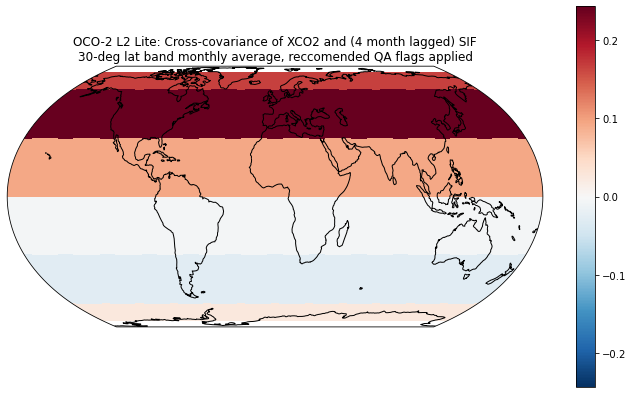

In [9]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(da_xcov_monthly.T, robust=True,
                   transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Cross-covariance of XCO2 and (4 month lagged) SIF\n" 
             "30-deg lat band monthly average, reccomended QA flags applied")

plt.savefig("../plots/30deg-band_monthly_xcov.png");